In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

In [13]:
df = pd.read_excel("1730285881-Airbnb_Open_Data.xlsx", engine='openpyxl')


In [14]:
print("Shape:", df.shape)   # shows rows and columns
df.head()                   # shows first 5 rows

Shape: (102599, 26)


,id,NAME,host id,host_identity_verified,host name,neighbourhood group,neighbourhood,lat,long,country,...,service fee,minimum nights,number of reviews,last review,reviews per month,review rate number,calculated host listings count,availability 365,house_rules,license
0,1001254,Clean & quiet apt home by the park,80014485718,unconfirmed,Madaline,Brooklyn,Kensington,40.64749,-73.97237,United States,...,193.0,10.0,9.0,2021-10-19,0.21,4.0,6.0,286.0,Clean up and treat the home the way you'd like...,NaN
1,1002102,Skylit Midtown Castle,52335172823,verified,Jenna,Manhattan,Midtown,40.75362,-73.98377,United States,...,28.0,30.0,45.0,2022-05-21,0.38,4.0,2.0,228.0,Pet friendly but please confirm with me if the...,NaN
2,1002403,THE VILLAGE OF HARLEM....NEW YORK !,78829239556,NaN,Elise,Manhattan,Harlem,40.80902,-73.94190,United States,...,124.0,3.0,0.0,NaT,NaN,5.0,1.0,352.0,"I encourage you to use my kitchen, cooking and...",NaN
3,1002755,NaN,85098326012,unconfirmed,Garry,Brooklyn,Clinton Hill,40.68514,-73.95976,United States,...,74.0,30.0,270.0,2019-07-05,4.64,4.0,1.0,322.0,NaN,NaN
4,1003689,Entire Apt: Spacious Studio/Loft by central park,92037596077,verified,Lyndon,Manhattan,East Harlem,40.79851,-73.94399,United States,...,41.0,10.0,9.0,2018-11-19,0.10,3.0,1.0,289.0,"Please no smoking in the house, porch or on th...",NaN


In [17]:
# normalize column names for convenience
df.columns = df.columns.str.strip().str.lower().str.replace('[ /]+', '_', regex=True)

print("Columns:")
print(df.columns.tolist())

print("\nInfo:")
display(df.info())

print("\nMissing values (top 20):")
display(df.isnull().sum().sort_values(ascending=False).head(20))


Columns:
['id', 'name', 'host_id', 'host_identity_verified', 'host_name', 'neighbourhood_group', 'neighbourhood', 'lat', 'long', 'country', 'country_code', 'instant_bookable', 'cancellation_policy', 'room_type', 'construction_year', 'price', 'service_fee', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 'review_rate_number', 'calculated_host_listings_count', 'availability_365', 'house_rules', 'license']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102599 entries, 0 to 102598
Data columns (total 26 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   id                              102599 non-null  int64         
 1   name                            102329 non-null  object        
 2   host_id                         102599 non-null  int64         
 3   host_identity_verified          102310 non-null  object        
 4   host_name                    

None


Missing values (top 20):


license                           102597
house_rules                        54843
last_review                        15893
reviews_per_month                  15879
country                              532
availability_365                     448
minimum_nights                       409
host_name                            408
review_rate_number                   326
calculated_host_listings_count       319
host_identity_verified               289
service_fee                          273
name                                 270
price                                247
construction_year                    214
number_of_reviews                    183
country_code                         131
instant_bookable                     105
cancellation_policy                   76
neighbourhood_group                   29
dtype: int64

In [19]:
def find_col(df, keywords):
    cols = df.columns.tolist()
    for k in keywords:
        for c in cols:
            if k in c:
                return c
    return None

price_col = find_col(df, ['price', 'amount', 'cost'])
room_col = find_col(df, ['room_type', 'roomtype', 'room'])
neigh_col = find_col(df, ['neighbour', 'neighborhood', 'neighbourhood_group', 'neighborhood_cleansed'])
reviews_col = find_col(df, ['number_of_reviews','reviews','review_count'])
revpm_col = find_col(df, ['reviews_per_month'])
last_review_col = find_col(df, ['last_review', 'last_review_date', 'date_last_reviewed'])
name_col = find_col(df, ['name', 'listing_name', 'title'])
lat_col = find_col(df, ['latitude', 'lat'])
lon_col = find_col(df, ['longitude', 'lng', 'lon'])

print("Auto-detected mapping:")
for var, col in [('price', price_col), ('room', room_col), ('neighbourhood', neigh_col),
                 ('reviews', reviews_col), ('reviews_per_month', revpm_col),
                 ('last_review', last_review_col), ('name', name_col),
                 ('lat', lat_col), ('lon', lon_col)]:
    print(f" {var:18}: {col}")


Auto-detected mapping:
 price             : price
 room              : room_type
 neighbourhood     : neighbourhood_group
 reviews           : number_of_reviews
 reviews_per_month : reviews_per_month
 last_review       : last_review
 name              : name
 lat               : lat
 lon               : long


In [21]:
print("Duplicates (initial):", df.duplicated().sum())
df = df.drop_duplicates().reset_index(drop=True)
print("After drop duplicates shape:", df.shape)


Duplicates (initial): 541
After drop duplicates shape: (102058, 26)


In [23]:
if price_col is not None:
    # remove currency symbols and commas then convert
    df[price_col] = df[price_col].astype(str).str.replace(r'[^\d\.\-]', '', regex=True)
    df[price_col] = pd.to_numeric(df[price_col], errors='coerce')

    # inspect distribution
    print("price: nulls =", df[price_col].isnull().sum())
    print(df[price_col].describe())

    # fill missing prices with median (robust to outliers)
    median_price = df[price_col].median(skipna=True)
    df[price_col] = df[price_col].fillna(median_price)
    print("Filled missing price with median:", median_price)
else:
    print("No price column detected. Set price_col manually if needed.")


price: nulls = 247
count    101811.000000
mean        625.355580
std         331.672649
min          50.000000
25%         340.000000
50%         625.000000
75%         913.000000
max        1200.000000
Name: price, dtype: float64
Filled missing price with median: 625.0


In [25]:
if last_review_col is not None:
    df[last_review_col] = pd.to_datetime(df[last_review_col], errors='coerce')
    print("Parsed dates; earliest and latest:")
    print(df[last_review_col].min(), df[last_review_col].max())
else:
    print("No date-like column detected for last_review.")


Parsed dates; earliest and latest:
2012-07-11 00:00:00 2058-06-16 00:00:00


In [27]:
if reviews_col is not None:
    df[reviews_col] = pd.to_numeric(df[reviews_col], errors='coerce').fillna(0).astype(int)

if revpm_col is not None:
    df[revpm_col] = pd.to_numeric(df[revpm_col], errors='coerce').fillna(0.0)

if lat_col is not None:
    df[lat_col] = pd.to_numeric(df[lat_col], errors='coerce')
if lon_col is not None:
    df[lon_col] = pd.to_numeric(df[lon_col], errors='coerce')


In [29]:
for c in df.select_dtypes(include='object').columns:
    if df[c].isnull().any():
        try:
            mode = df[c].mode(dropna=True)[0]
        except Exception:
            mode = 'Unknown'
        df[c] = df[c].fillna(mode)

# quick missing check
display(df.isnull().sum().sort_values(ascending=False).head(20))


last_review                       15832
availability_365                    448
minimum_nights                      400
calculated_host_listings_count      319
review_rate_number                  319
service_fee                         273
construction_year                   214
instant_bookable                    105
lat                                   8
long                                  8
id                                    0
price                                 0
house_rules                           0
reviews_per_month                     0
number_of_reviews                     0
room_type                             0
name                                  0
cancellation_policy                   0
country_code                          0
country                               0
dtype: int64

In [31]:
if price_col is not None:
    q_low = df[price_col].quantile(0.01)
    q_high = df[price_col].quantile(0.99)
    print("99% price:", q_high, "1% price:", q_low)

    # create a capped price column for plotting
    df['price_capped'] = df[price_col].clip(lower=q_low, upper=q_high)


99% price: 1188.0 1% price: 61.0


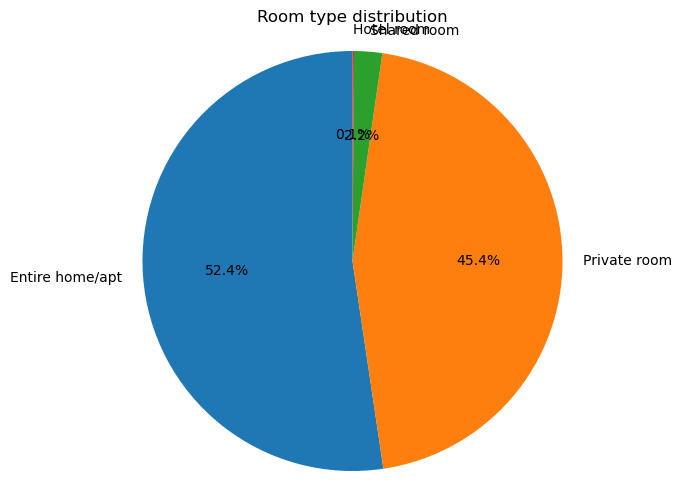

In [33]:
if room_col is None:
    print("No room-type column. Set room_col = 'your_column_name' and re-run.")
else:
    counts = df[room_col].value_counts()
    plt.figure(figsize=(7,6))
    plt.pie(counts.values, labels=counts.index, autopct='%1.1f%%', startangle=90)
    plt.title("Room type distribution")
    plt.axis('equal')
    plt.show()


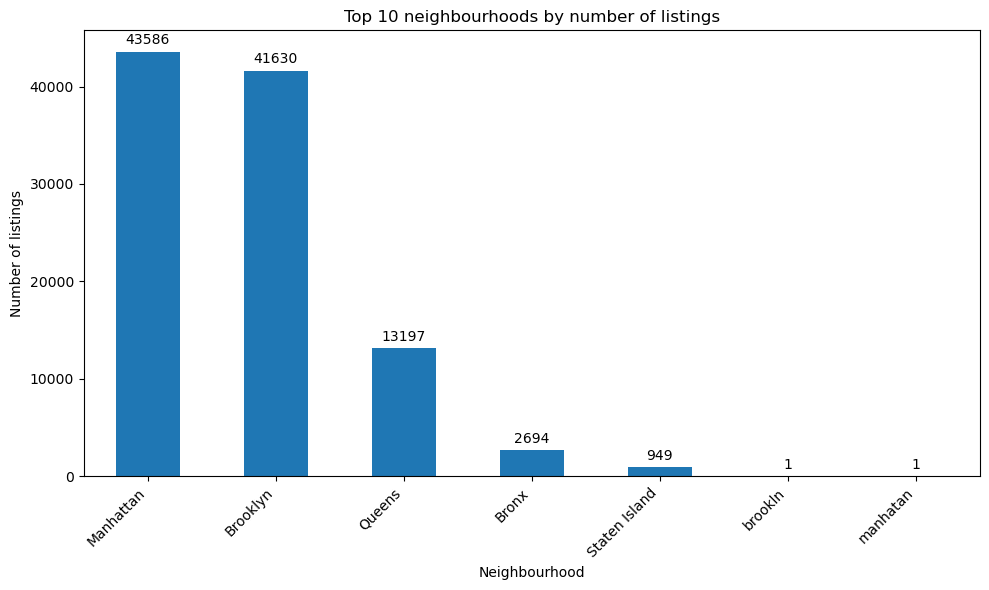

In [35]:
if neigh_col is None:
    print("No neighbourhood column found.")
else:
    top10 = df[neigh_col].value_counts().head(10)
    ax = top10.plot(kind='bar', figsize=(10,6))
    plt.title("Top 10 neighbourhoods by number of listings")
    plt.ylabel("Number of listings")
    plt.xlabel("Neighbourhood")
    # annotate counts above bars
    for p in ax.patches:
        ax.annotate(int(p.get_height()), (p.get_x()+p.get_width()/2., p.get_height()), 
                    ha='center', va='bottom', xytext=(0,3), textcoords='offset points')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


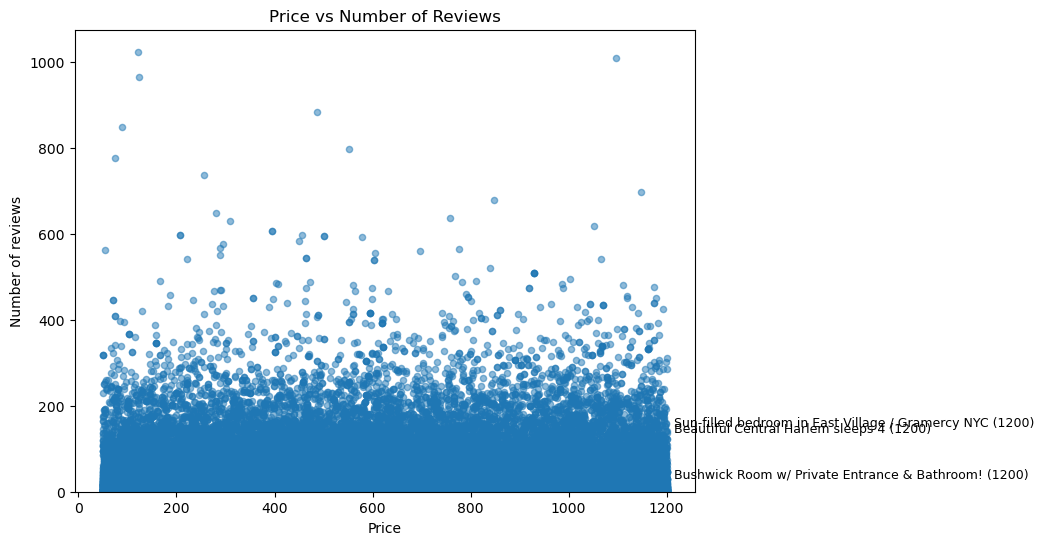

In [37]:
if price_col is None or reviews_col is None:
    print("Need both price and reviews columns for scatter.")
else:
    x = df[price_col]
    y = df[reviews_col]
    plt.figure(figsize=(8,6))
    plt.scatter(x, y, alpha=0.5, s=20)
    plt.xlabel("Price")
    plt.ylabel("Number of reviews")
    plt.title("Price vs Number of Reviews")

    # annotate top-3 most expensive listings (if name is available)
    if name_col is not None:
        top3 = df.nlargest(3, price_col)
        for _, r in top3.iterrows():
            plt.annotate(f"{r[name_col]} ({int(r[price_col])})", 
                         xy=(r[price_col], r[reviews_col]), xytext=(5,5), textcoords='offset points', fontsize=9)
    plt.ylim(bottom=0)
    plt.show()


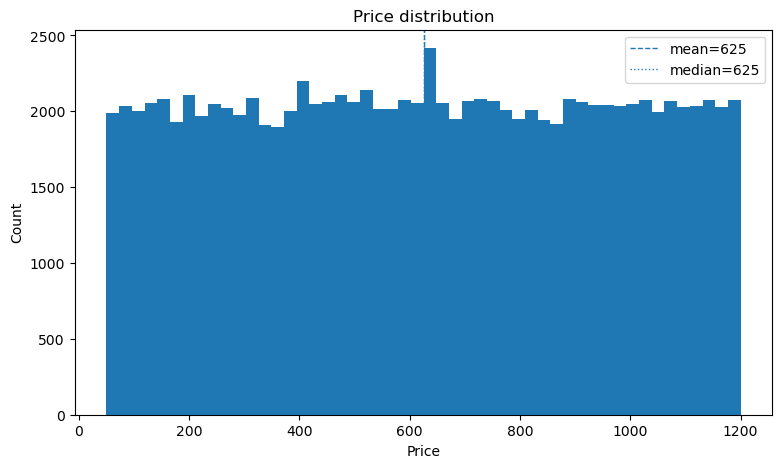

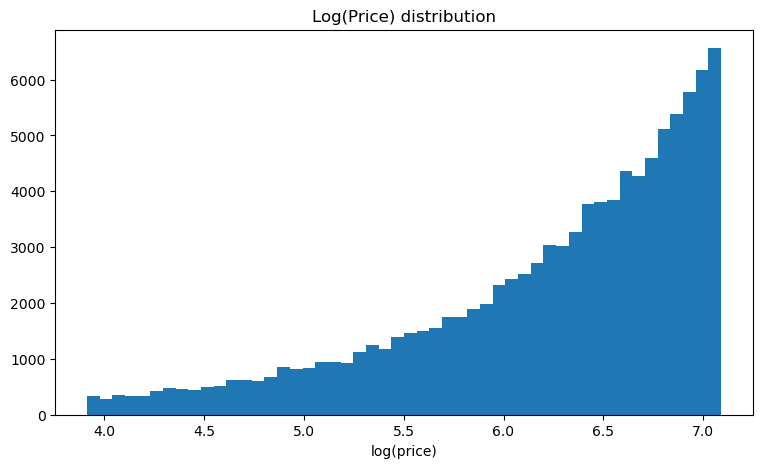

In [39]:
if price_col is None:
    print("No price column.")
else:
    vals = df[price_col].dropna()
    plt.figure(figsize=(9,5))
    plt.hist(vals, bins=50)
    mean_price = vals.mean()
    median_price = vals.median()
    plt.axvline(mean_price, linestyle='dashed', linewidth=1, label=f"mean={mean_price:.0f}")
    plt.axvline(median_price, linestyle='dotted', linewidth=1, label=f"median={median_price:.0f}")
    plt.legend()
    plt.title("Price distribution")
    plt.xlabel("Price")
    plt.ylabel("Count")
    plt.show()

    # Optional: log histogram if heavily skewed
    if (vals > 0).all():
        plt.figure(figsize=(9,5))
        plt.hist(np.log(vals), bins=50)
        plt.title("Log(Price) distribution")
        plt.xlabel("log(price)")
        plt.show()


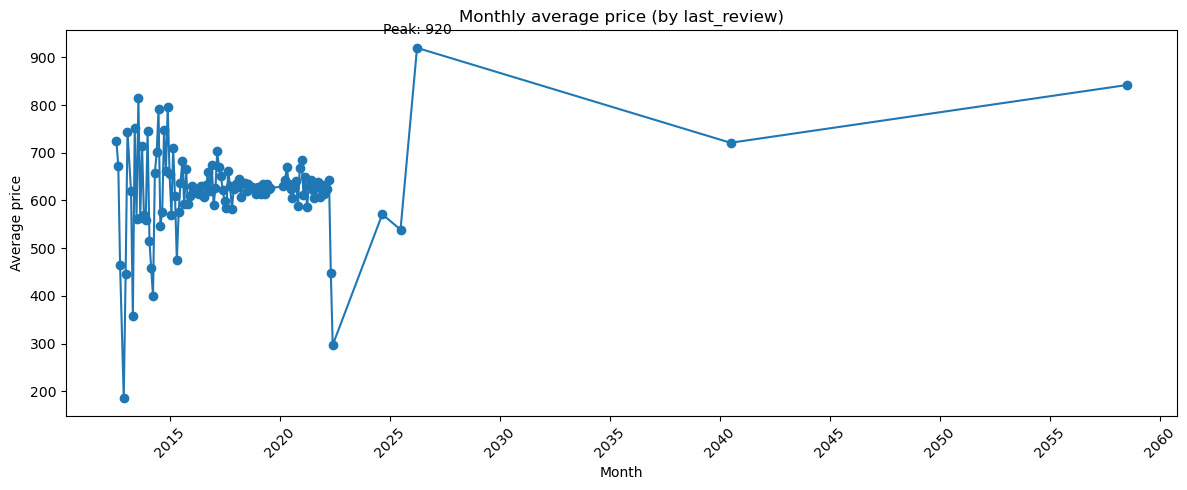

In [41]:
if price_col is not None and last_review_col is not None:
    # restrict to rows with a date
    df_dates = df.dropna(subset=[last_review_col])
    if df_dates.empty:
        print("No rows with a valid last_review date.")
    else:
        monthly = df_dates.set_index(last_review_col)[price_col].resample('M').mean().dropna()
        plt.figure(figsize=(12,5))
        plt.plot(monthly.index, monthly.values, marker='o')
        plt.title("Monthly average price (by last_review)")
        plt.xlabel("Month")
        plt.ylabel("Average price")
        # annotate peak
        peak_idx = monthly.idxmax()
        peak_val = monthly.max()
        plt.annotate(f"Peak: {peak_val:.0f}", xy=(peak_idx, peak_val), xytext=(0,10), textcoords='offset points', ha='center')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
else:
    print("Need both price and a date column (last_review) for monthly averages.")
